# Colaboratoryで実行する場合
以下を実行して、外部ファイルをダウンロードしてください。   
**このセルはColaboratoryを起動するたびに必要となります**

In [ ]:
##################################
### Colaboratoryのみ以下を実行 ###
##################################
import sys
if 'google.colab' in sys.modules:
    !wget -P ./sound http://www.hal.t.u-tokyo.ac.jp/~yamakata/lecture/mediaproc/mediaproc2/sound/3-female_a.wav
    !wget -P ./sound http://www.hal.t.u-tokyo.ac.jp/~yamakata/lecture/mediaproc/mediaproc2/sound/3-female_i.wav
    !wget -P ./sound http://www.hal.t.u-tokyo.ac.jp/~yamakata/lecture/mediaproc/mediaproc2/sound/3-male_a.wav
    !wget -P ./sound http://www.hal.t.u-tokyo.ac.jp/~yamakata/lecture/mediaproc/mediaproc2/sound/3-male_i.wav
    !mkdir fig


# 音の情報処理3：周波数分解、フーリエ変換、逆フーリエ変換

## 1. 周波数分解
### 1.1 波形の読み込み
皆さんにとって一番なじみのある音、音声について分析していきましょう。   

`3-female_a.wav`、`3-female_i.wav`はそれぞれ女性が「あ」「い」と発した音声です。  
また、`3-male_a.wav`、`3-male_i.wav`はそれぞれ男性が「あ」「い」と発した音声です。  
両者の声が高さが違いますが、音声認識では、1つ目と3つ目がどちらも「あ」であり、2つ目と4つ目がどちらも「い」であると認識しますよね。   
どうやって聞き分けているのでしょうか？

波形を描画して見比べてみましょう。


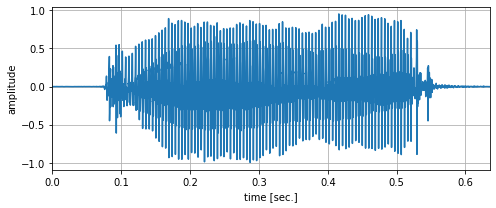

In [1]:
%matplotlib inline
import wave
import numpy as np
import matplotlib.pyplot as plt

# 読み込むファイルをいろいろと替えて見比べてみましょう
wavfile = wave.open('sound/3-female_a.wav', 'rb')
# wavfile = wave.open('sound/3-female_i.wav', 'rb')
# wavfile = wave.open('sound/3-male_a.wav', 'rb')
# wavfile = wave.open('sound/3-male_i.wav', 'rb')

x = wavfile.readframes(wavfile.getnframes()) # 波形の読み込み
sampling_rate = wavfile.getframerate()  # フレームレート[1/s]
sample_size = wavfile.getsampwidth() # 1サンプルあたりのサイズ
wavfile.close()

x = np.frombuffer(x, dtype= "int16") # バイナリデータをint型に変換
x = x/(2**(8 * sample_size) / 2)# 正規化
xlabel = np.arange(0, len(x)/sampling_rate, 1.0/sampling_rate) # X軸ラベルの生成

fig = plt.figure(figsize=(7, 3)) # figure(図を配置する画面)のサイズを指定
ax = plt.subplot() # figureには複数の図を配置できるので、そのうち図を1つ描画する空間を準備

ax.plot(xlabel, x) # 波形を描画
ax.set_xlabel("time [sec.]")
ax.set_ylabel("amplitude")
ax.set_xlim([0, len(x)/sampling_rate]) # x軸の範囲を、0秒からこの音ファイルの最後までに制限
ax.grid()  #生成网格
fig.tight_layout() # 図がはみ出さないようにレイアウト
#ax.set_xlim(0.2,0.23) # <---- 拡大したいときはこのコメントを外してください。下のグラフを直接ズームすることもできます。
plt.savefig('fig/SoundProcessing3-1.png') # 図を画像として保存

## 1.2 周波数分解：離散フーリエ変換
波形を周波数成分に分解してみましょう。  
周波数分解は波形の信号処理の基本中の基本です。理系学部では必ず学ぶ内容でしょう。  
また、株価や消費の変動など周期性があるデータの分析では第一の選択肢と言えるでしょう。  
ここではその詳細は説明しませんが、もし学んでいない人はこの実験の後にでも必ず概要は理解しておいてください。

フーリエ変換はもともと連続値（アナログ値）を解析する手法として発明されましたが、コンピュータで実行するには離散値（デジタル値）で計算できる必要があるため、その離散値版である離散フーリエ変換（Discrete Fourier Transform、DFT）を使います。  
DFTは高速フーリエ変換（Fast Fourier Transform, FFT）というアルゴリズムにより高速に計算することができるので、通常コンピュータではFFTを使って計算します。  
また、フーリエ変換によって得られた周波数成分を**周波数スペクトル**と呼びます。

In [2]:
%matplotlib inline

import wave
import numpy as np

### まずは女性の「あ」の音声を読み込み
wavfile = wave.open('sound/3-female_a.wav', 'rb')
x = wavfile.readframes(wavfile.getnframes()) # 波形の読み込み
sampling_rate = wavfile.getframerate()  # フレームレート[1/s]
sample_size = wavfile.getsampwidth() # 1サンプルあたりのサイズ
wavfile.close()

x = np.frombuffer(x, dtype= "int16") # バイナリデータをint型に変換
x = x/(2**(8 * sample_size) / 2)# 正規化

### FFTで高速フーリエ変換
X = np.fft.fft(x)  
# フーリエ変換後のベクトルは波形と同じ要素数
print("len(x): ", len(x), " len(X): ", len(X))

len(x):  10161  len(X):  10161


## 1.3 複素数による振幅と位相の表現

この$X$はもとの波$x$と同じ長さの複素数の配列です。  
この一つ一つの複素数がそれぞれ一つの周波数の波の成分に相当します。  
どういうことでしょうか？

分解した1つ1つの波はある一つの周波数の波に対応する、すなわち正弦波ですから、振幅と位相が1つ決まれば一意に決まります。  
このような正弦波は、極座標中の1点で表すことができます。  
その理由は以下の通りです。

$x = a + b i$という複素数を考えます。$a$は実部、$b$は虚部です。  
$a$をx座標、$b$をy座標とした2次元平面中の1点からスタートし、原点を中心とした円を回るとしましょう。  
このとき、その点のy座標だけに注目すると、点が上下して波を形成しているのがわかります。   
下のような図を考えればわかるでしょうか。  

<img src='http://www.hal.t.u-tokyo.ac.jp/~yamakata/lecture/mediaproc/mediaproc2/fig/wave_as_complexN.png' width="640">

このとき、振幅は$A = \sqrt{a^2+b^2}$、位相は$\theta = \tan^{-1}( \dfrac{b}{a})$となります。  
ここで$\tan^{-1}(x)$とは、$\tan (y) = x$となるような角度$y$のことです。

## 2. 音声の周波数成分：周波数スペクトル
### 2.1 音声の振幅成分
それでは音$x$をフーリエ変換して得られた複素ベクトル$X$のうち、まず振幅成分を見て見ましょう。  
前述の通り、これは$A = \sqrt{a^2 + b^2}$で計算できました。   

ただし、このままだと周波数による$A$の幅が非常に大きく、周波数ごとの成分の大きさを比較しづらいこと、  
また前述の通り、「人間の感覚量は刺激量の対数に比例する」というウェーバ・フェヒナーの法則があり、聴覚もこれに従うことから、  
振幅は対数尺度であるデシベル(dB)で表します。   

音量（dB SPL)は、測定された音圧を$p$、基準となる音圧の実効値を$p_0$とすると、
音圧レベル$L_p$（dB）は次の式で与えられます。   
$$L_p = 10 \times \log_{10} \dfrac{p^2}{{p_0}^2} = 20 \times \log_{10} \dfrac{p}{p_0}$$

ただし、実際の音圧を測るには騒音計のような専用の収録機器を用いる必要があり、通常のマイクロフォンは音圧値は計測できない（音圧の時間変化しか計測できない）ことから、便宜上$p_0 = 1$とします（この場合は相対値でしかないので、単位には、絶対値であるところの[dB SPL]という単位は使えず、単に[dB]となります）。

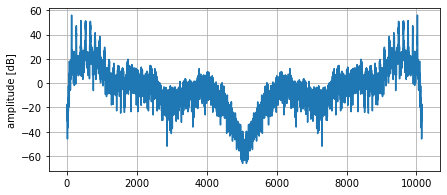

In [3]:
#amplitude = [20*np.log(np.sqrt(c.real ** 2 + c.imag ** 2)) for c in X]  # 振幅スペクトル
# 上の式と下の式は同じですが、下の式のほうが高速です。
amplitude = 20*np.log10(np.abs(X))  # 振幅スペクトル

fig = plt.figure(figsize=(7, 3)) # figure(図を配置する画面)のサイズを指定
ax = plt.subplot() # figureには複数の図を配置できるので、そのうち図を1つ描画する空間を準備
ax.plot(amplitude)
ax.set_ylabel("amplitude [dB]")
ax.grid()
plt.savefig('fig/SoundProcessing3-2.png') # 図を画像として保存

左右対象のグラフが出てきました。  
この元の波は女性が「あ」と発した音声で、サンプリング周波数は16kHzでした。  
中央から左側の山はこの音声の0～8kHzまでの周波数成分を表しています。  
一方、真ん中（ナイキスト周波数）よりも大きい（右側）山はそのナイキスト成分です。  
(SoundProcessing2の「1.3 サンプリング定理」で紹介した通り、サンプリング周波数の1/2の周波数を **ナイキスト周波数** と呼びます）。

「音の情報処理２」で、サンプリング周波数が$F$Hzのとき、周波数$f$Hzの波と周波数$F-f$Hzの波は区別できないと説明しました。  
たとえば440Hzの波に対して、左側に$f=440$の成分が現れ、右側には$f' = (44100-440)$の成分が現れているということです。  
サンプリング周波数が$F$のとき、ナイキスト周波数$F/2$よりも高い周波数の波は記録できていないはずなので、ナイキスト周波数よりも高い周波数成分は無視します。

下の図は、ナイキスト周波数よりも低い周波数成分のみを残したグラフです。   
これが一般的な周波数成分のグラフです。

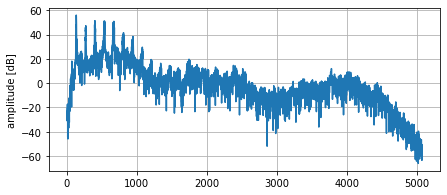

In [4]:
fig = plt.figure(figsize=(7, 3)) # figure(図を配置する画面)のサイズを指定
ax = plt.subplot() # figureには複数の図を配置できるので、そのうち図を1つ描画する空間を準備
ax.plot(amplitude[0:int(len(X)/2)])
ax.set_ylabel("amplitude [dB]")
ax.grid()
plt.savefig('fig/SoundProcessing3-3.png') # 図を画像として保存

この複素ベクトルの要素数は10161でした。これは元の「あ」の音声波の長さと同じです。  
今、このうちの最初の半分である5080成分だけを取ってきました。  
ここに、$0$から$F/2$までの周波数成分が記録されているということになります。  
よってx軸は0から5080までのデータに対し0から$2/F$までの周波数を割り当てるということになります。  
ここで、$F=16000$ですから、  
[0, 1, 3, ..., 5080]/10161×16000   
がx軸の周波数のメモリとなります。

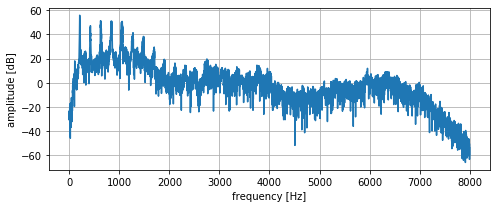

In [5]:
x_axis = [i/len(X)*sampling_rate for i in range(0, int(len(X)/2)-1)]
# 実はこの周波数軸の値の計算は以下のような関数が用意されています
# x_axis = np.fft.fftfreq(len(X), d=1.0/sampling_rate) 

# 振幅スペクトルを描画
fig = plt.figure(figsize=(7, 3)) # figure(図を配置する画面)のサイズを指定
ax = plt.subplot() # figureには複数の図を配置できるので、そのうち図を1つ描画する空間を準備
ax.plot(x_axis[0:int(len(X)/2-1)], amplitude[0:int(len(X)/2)-1])
ax.set_xlabel("frequency [Hz]")
ax.set_ylabel("amplitude [dB]")
ax.grid()
fig.tight_layout() # 図がはみ出さないようにレイアウト
plt.savefig('fig/SoundProcessing3-4.png') # 図を画像として保存

このように、周波数分解したものを**周波数スペクトル**と呼び、このうち特に振幅成分を取り出しdB値に変換したものを**パワースペクトル**と呼びます。

母音音声の特徴は4kHzまでによく表れているといわれます。     
今回はさらに狭い範囲で0～2000Hzを拡大してみましょう。

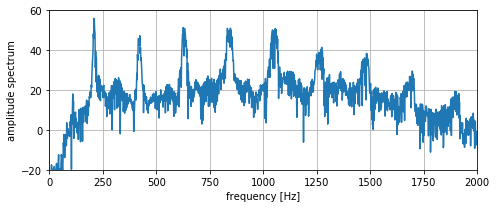

In [6]:
# 振幅スペクトルを描画
fig = plt.figure(figsize=(7, 3)) # figure(図を配置する画面)のサイズを指定
ax = plt.subplot() # figureには複数の図を配置できるので、そのうち図を1つ描画する空間を準備
ax.plot(x_axis[0:int(len(X)/2-1)], amplitude[0:int(len(X)/2)-1])
ax.set_xlim(0, 2000) # X軸の値域を0～2000Hzに限りる
ax.set_ylim(-20, 60) # Y軸の値域を-20～60dBに限る
ax.set_xlabel("frequency [Hz]")
ax.set_ylabel("amplitude spectrum")
ax.grid()
fig.tight_layout() # 図がはみ出さないようにレイアウト
plt.savefig('fig/SoundProcessing3-5.png') # 図を画像として保存

特に低周波にとげとげがあるのが分かりますね。

このとげとげの頂点の周波数を調べてみると、一番下の周波数成分は209Hz、2番目の周波数成分は420Hz、3番目の成分は627Hz,...  
と、一番下の周波数成分(209Hz)の概ね整数倍になっていることがわかります。  

人間の声は、声帯で発生した音はまるでブザーのような音で、それを口腔や鼻腔で増幅させて声にします。  
この音の発生の過程で、高い周波数までの倍音（つまり波長が1/2, 1/3, 1/4...の波）が発生します。  
上のグラフに出てくる山は、この倍音成分を表しています。  

なお、楽器の音も同じで、単音だとこのような倍音成分が見られます（課題で分析してもらいます）。
弦やリードなどで発生させた波を、それを囲む筐体によって増幅させることにより豊かな音色の音を発生しています。  

このような倍音構造をもつ音の中で、もっとも低い周波数成分を基本周波数（Fondamental Frequency, F0)と呼びます。  
音の高さ（音高、ピッチ）はこの基本周波数で決まります。  
この音声はおおよそ209Hzの音というわけです。

### 2.2 音声の位相成分

一方、位相は$\tan^{-1}( \dfrac{b}{a})$で計算できます。   
これは可視化してもよくわかりませんね。  
ですが、必要ないと思って捨ててしまわないでください。   
後述するとおり、フーリエ変換では逆フーリエ変換によって周波数成分をまた元の波形に戻すことができ、このときに位相成分が必要です。   

max:  3.141592653589793 min:  -3.133094274617535


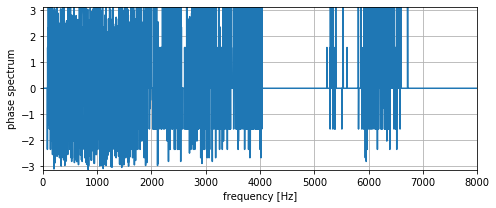

In [7]:
phase = [np.arctan2(int(c.imag), int(c.real)) for c in X[0:int(len(X)/2)-1]]    # 位相スペクトル
# phaseは位相ですから、-πからπまでの値を取ります。
print("max: ", max(phase), "min: ", min(phase))

fig = plt.figure(figsize=(7, 3)) # figure(図を配置する画面)のサイズを指定
ax = plt.subplot() # figureには複数の図を配置できるので、そのうち図を1つ描画する空間を準備
# 位相スペクトルを描画
ax.plot(x_axis, phase)
ax.set_xlim(0, sampling_rate/2)
ax.set_ylim(-np.pi, np.pi)
ax.set_xlabel("frequency [Hz]")
ax.set_ylabel("phase spectrum")
ax.grid()
fig.tight_layout() # 図がはみ出さないようにレイアウト
plt.savefig('fig/SoundProcessing3-6.png') # 図を画像として保存

## 3. 周波数空間におけるフィルタリングと逆フーリエ変換
フーリエ変換では逆フーリエ変換によって周波数成分をまた元の波形に戻すことができます。   
例えば波形をフーリエ変換して周波数成分にした後、振幅成分にフィルタ（例えば4kHz以上の周波数成分を0にしたり、振幅成分を小さくするなど）をかけた後で、また位相成分と合わせて逆フーリエ変換にかけ、波形に戻すこともできます（このときの音は、高い音の成分がなくなったり小さくなっていることになります）。

試しに、先ほどの波の1kHz以上を除去してみましょう。

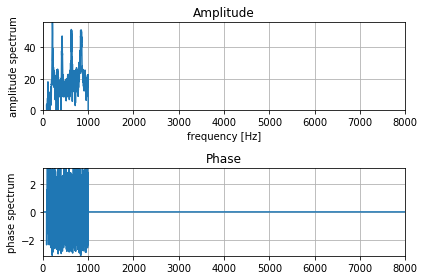

In [8]:
import copy

Th = 1000 # Th Hzより高い周波数成分を除去する

Filtered_X = copy.deepcopy(X) # もとの波形の周波数成分をコピー
# Th Hzより高い成分を微小な値(ここでは0.001)に置き換える
Filtered_X[int(len(X)/(sampling_rate)*Th):int(len(X)-len(X)/(sampling_rate)*Th)] = 0.001 + 0.001j 
# フィルタリング後の周波数成分を可視化します
Filtered_amplitude = 20*np.log10(np.abs(Filtered_X))  # 振幅スペクトル
Filtered_phase = [np.arctan2(int(c.imag), int(c.real)) for c in Filtered_X[0:int(len(X)/2)-1]]    # 位相スペクトル

fig = plt.figure(figsize=(6, 4)) # figure(図を配置する画面)のサイズを指定
ax0 = plt.subplot(2,1,1)
ax1 = plt.subplot(2,1,2)

# 振幅スペクトルを描画
ax0.plot(x_axis[0:int(len(X)/2-1)], Filtered_amplitude[0:int(len(X)/2)-1])
ax0.set_xlim(0, sampling_rate/2)
ax0.set_ylim(0, max(Filtered_amplitude))
ax0.set_xlabel("frequency [Hz]")
ax0.set_ylabel("amplitude spectrum")
ax0.set_title('Amplitude')
ax0.grid()

# 位相スペクトルを描画
ax1.plot(x_axis, Filtered_phase)
ax1.set_xlim(0, sampling_rate/2)
ax1.set_ylim(-np.pi, np.pi)
ax1.set_ylabel("phase spectrum")
ax1.set_title('Phase')
ax1.grid()

# 周波数空間から実空間に戻す
Filtered_x = np.fft.ifft(Filtered_X) # 逆フーリエ変換をかける
Filtered_x = Filtered_x.real # 実部のみを取り出す
# 最大値で正規化して、2倍との整数表現(int16)に変換する（音量調節していることと同じ）
# 音が大きくなりすぎないように0.9をかけている
Filtered_x = np.int16(0.9*Filtered_x/max(Filtered_x)*2**15)

# wavファイルとして保存する
Filtered_wavfile = wave.open('sound/Filtered.wav', "w")
Filtered_wavfile.setnchannels(1) # チャネル数は１（モノラル音源）
Filtered_wavfile.setsampwidth(2) # サンプル幅は2byte(=int16)
Filtered_wavfile.setframerate(sampling_rate) # サンプリングレートはfs(元の波形と同じ)
Filtered_wavfile.writeframes(Filtered_x)
Filtered_wavfile.close()

fig.tight_layout() # 図がはみ出さないようにレイアウト
plt.savefig('fig/SoundProcessing3-7.png') # 図を画像として保存

フィルター前の音の波形とフィルター後の音の波形を並べて描画してみましょう。   
一見同じように見えますね。では音を聞いてみましょう。   
（生成されたwavファイルをクリックして再生して聞き比べてみてください）

元の音のファイル： 3-female_a.wav   
フィルタ後のファイル：Filtered.wav

元の音に比べ、フィルタ後の音は籠ったように聞こえたでしょうか？   
これは高周波成分が除去されたことによる効果です。

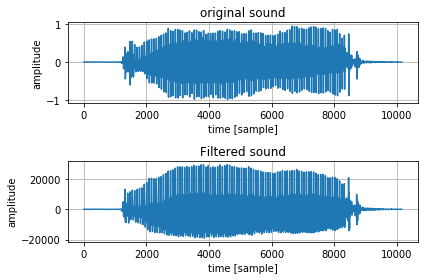

In [9]:
# 波形を描画
fig = plt.figure(figsize=(6, 4)) # figure(図を配置する画面)のサイズを指定
ax0 = plt.subplot(2,1,1)
ax1 = plt.subplot(2,1,2)

ax0.plot(x)
ax0.set_title('original sound')
ax0.set_xlabel("time [sample]")
ax0.set_ylabel("amplitude")
ax0.grid()

ax1.plot(Filtered_x)
ax1.set_title('Filtered sound')
ax1.set_xlabel("time [sample]")
ax1.set_ylabel("amplitude")
ax1.grid()

fig.tight_layout() # 図がはみ出さないようにレイアウト
plt.savefig('fig/SoundProcessing3-8.png') # 図を画像として保存